<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/CelebA_Conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime


warnings.filterwarnings('ignore')

In [2]:
FOLDER_NUMBER = 5 # Change to put checkpoints into different folders
SAMPLE_COUNT = 50_000

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cuda


In [5]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

Using Colab cache for faster access to the 'face-vae' dataset.


In [6]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [8]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=758, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 66
Sample shape: torch.Size([3, 256, 256])


In [9]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

VERY IMPORTANT: This should be Jim from The Office

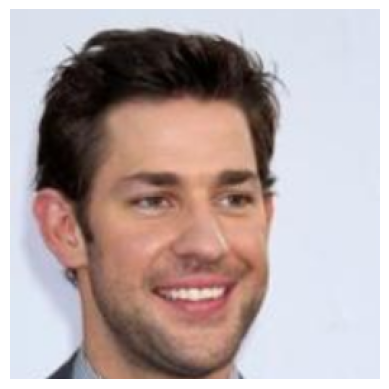

In [10]:
plot_image(dataset[0])

In [11]:
def conv_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size + 2 * padding - kernel_size) // stride + 1

In [12]:
def convtranspose_output_size(input_size, kernel_size, stride=1, padding=0, output_padding=0):
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding

In [13]:
conv_output_size(64, 4, 2, 1)

32

In [14]:
convtranspose_output_size(16, 4, 2, 1)

32

In [15]:
# --- Convolutional VAE ---
class ConvVAE(nn.Module):
    def __init__(self, latent_dimension: int, image_channels: int):
        super().__init__()
        self.latent_dim = latent_dimension
        self.image_channels = image_channels
        self.W_lat = 16
        self.H_lat = 16

        # Encoder: 3x256x256
        # -conv> 8x256x256
        # -conv> 16x256x256
        # -conv> 32x64x64
        # -conv> 64x64x64
        # -conv> 128x32x32
        # -conv> 256x32x32
        # -conv> 512x16x16
        # -conv> latent_dimx16x16 (latent_dim=512)
        # -flatten> 131072
        # -fcx2> latent_dim (mu, logvar)
        self.enc = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=8, stride=4, padding=2),  # 64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64x64
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(512, self.latent_dim, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
        )
        # Flatten (in decode)
        self.enc_fc_mu = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)
        self.enc_fc_logvar = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)

        # Decoder: latent_dim (z)
        # -fc> 131072
        # -reshape(in decode)> 512x16x16
        # -deconv> 512x16x16
        # -deconv> 256x16x16
        # -deconv> 128x32x32
        # -deconv> 32x64x64
        # -deconv> 16x64x64
        # -deconv> 8x256x256
        # -deconv> image_channelsx256x256
        self.dec_fc = nn.Linear(self.latent_dim, self.latent_dim * 16 * 16)
        # 16x16 (512)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 512, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=8, stride=4, padding=2),  # 256x256
            nn.ReLU(True),
            nn.ConvTranspose2d(8, image_channels, kernel_size=3, stride=1, padding=1),  # 256x256
            nn.Tanh(),  # output in [-1,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_vec):
        h = self.dec_fc(z_vec)
        h = h.view(z_vec.size(0), self.latent_dim, self.W_lat, self.H_lat)
        x_recon = self.dec(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_vec = self.reparameterize(mu, logvar)
        x_recon = self.decode(z_vec)
        return x_recon, mu, logvar

def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

vae = ConvVAE(latent_dimension=512, image_channels=3).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("VAE parameters (M):", sum(p.numel() for p in vae.parameters())/1e6)
print(vae)


VAE parameters (M): 210.578979
ConvVAE(
  (enc): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (enc_fc_mu): Linear(in_features=131072, out_features=512, bias=True)
  (enc_fc_logvar): Linear(in_f

In [16]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

In [18]:
drive.mount('/content/drive')

checkpoint_dir = Path(f'/content/drive/MyDrive/CS6524/VAE_checkpoints_{FOLDER_NUMBER}')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

Mounted at /content/drive


In [19]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [20]:
epoch, _ = load_checkpoint(vae, vae_opt, checkpoint_dir / 'latest.pt')
epoch

70

In [21]:
num_vae_epochs = 100

sum_loss_history = []
recon_loss_history = []
kl_loss_history = []

vae.train()
for epoch in range(epoch, num_vae_epochs):
    pbar = tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{num_vae_epochs}")

    total_sum_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.00
    total_kl_loss = 0.0

    for imgs in pbar:
        imgs = imgs.to(device)
        x_recon, mu, logvar = vae(imgs)
        loss, r_loss, kl = vae_loss(x_recon, imgs, mu, logvar)

        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()

        total_sum_loss += loss.item() * imgs.size(0)
        total_recon_loss += r_loss.item() * imgs.size(0)
        total_kl_loss += kl.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item(), "recon": r_loss.item(), "kl": kl.item()})

    save_checkpoint(vae, vae_opt, epoch, loss, checkpoint_dir / 'latest.pt')

    sum_loss_history.append(total_sum_loss / len(dataset))
    recon_loss_history.append(total_recon_loss / len(dataset))
    kl_loss_history.append(total_kl_loss / len(dataset))

    print(f"Epoch {epoch+1}: avg loss = {total_sum_loss/len(dataset):.4f}\n")


VAE Epoch 71/100: 100%|██████████| 66/66 [08:36<00:00,  7.83s/it, loss=3.31e+3, recon=2.57e+3, kl=742]


Epoch 71: avg loss = 3307.2287



VAE Epoch 72/100: 100%|██████████| 66/66 [03:10<00:00,  2.89s/it, loss=3.28e+3, recon=2.54e+3, kl=743]


Epoch 72: avg loss = 3475.1627



VAE Epoch 73/100: 100%|██████████| 66/66 [03:12<00:00,  2.92s/it, loss=4.16e+3, recon=3.41e+3, kl=750]


Epoch 73: avg loss = 3781.0179



VAE Epoch 74/100: 100%|██████████| 66/66 [03:14<00:00,  2.94s/it, loss=3.23e+3, recon=2.5e+3, kl=728]


Epoch 74: avg loss = 3373.9943



VAE Epoch 75/100: 100%|██████████| 66/66 [03:09<00:00,  2.86s/it, loss=3.28e+3, recon=2.53e+3, kl=749]


Epoch 75: avg loss = 3234.6750



VAE Epoch 76/100: 100%|██████████| 66/66 [03:15<00:00,  2.96s/it, loss=3.26e+3, recon=2.54e+3, kl=724]


Epoch 76: avg loss = 3187.3887



VAE Epoch 77/100: 100%|██████████| 66/66 [03:15<00:00,  2.96s/it, loss=3.18e+3, recon=2.43e+3, kl=746]


Epoch 77: avg loss = 3260.5254



VAE Epoch 78/100: 100%|██████████| 66/66 [03:14<00:00,  2.95s/it, loss=3.19e+3, recon=2.46e+3, kl=730]


Epoch 78: avg loss = 3259.0109



VAE Epoch 79/100: 100%|██████████| 66/66 [03:13<00:00,  2.93s/it, loss=3.15e+3, recon=2.41e+3, kl=741]


Epoch 79: avg loss = 3184.5829



VAE Epoch 80/100: 100%|██████████| 66/66 [03:14<00:00,  2.95s/it, loss=3.2e+3, recon=2.47e+3, kl=736]


Epoch 80: avg loss = 3233.7879



VAE Epoch 81/100: 100%|██████████| 66/66 [03:21<00:00,  3.05s/it, loss=3.23e+3, recon=2.48e+3, kl=750]


Epoch 81: avg loss = 3196.2153



VAE Epoch 82/100: 100%|██████████| 66/66 [03:16<00:00,  2.98s/it, loss=3.22e+3, recon=2.47e+3, kl=749]


Epoch 82: avg loss = 3181.0088



VAE Epoch 83/100: 100%|██████████| 66/66 [03:15<00:00,  2.96s/it, loss=3.4e+3, recon=2.68e+3, kl=719]


Epoch 83: avg loss = 3186.9990



VAE Epoch 84/100: 100%|██████████| 66/66 [03:18<00:00,  3.01s/it, loss=3.18e+3, recon=2.46e+3, kl=720]


Epoch 84: avg loss = 3064.7472



VAE Epoch 85/100: 100%|██████████| 66/66 [03:14<00:00,  2.95s/it, loss=3.23e+3, recon=2.48e+3, kl=747]


Epoch 85: avg loss = 3575.3340



VAE Epoch 86/100: 100%|██████████| 66/66 [03:12<00:00,  2.91s/it, loss=3.09e+3, recon=2.35e+3, kl=742]


Epoch 86: avg loss = 3016.4638



VAE Epoch 87/100: 100%|██████████| 66/66 [03:10<00:00,  2.89s/it, loss=3.03e+3, recon=2.29e+3, kl=741]


Epoch 87: avg loss = 3038.4165



VAE Epoch 88/100: 100%|██████████| 66/66 [03:12<00:00,  2.92s/it, loss=3.24e+3, recon=2.5e+3, kl=736]


Epoch 88: avg loss = 3082.4588



VAE Epoch 89/100: 100%|██████████| 66/66 [03:12<00:00,  2.91s/it, loss=2.97e+3, recon=2.22e+3, kl=746]


Epoch 89: avg loss = 3088.9504



VAE Epoch 90/100: 100%|██████████| 66/66 [03:10<00:00,  2.89s/it, loss=3.09e+3, recon=2.33e+3, kl=754]


Epoch 90: avg loss = 3035.3643



VAE Epoch 91/100: 100%|██████████| 66/66 [03:06<00:00,  2.83s/it, loss=7.14e+3, recon=6.37e+3, kl=764]


Epoch 91: avg loss = 10557.2129



VAE Epoch 92/100: 100%|██████████| 66/66 [03:02<00:00,  2.76s/it, loss=4.67e+3, recon=3.94e+3, kl=729]


Epoch 92: avg loss = 5508.1517



VAE Epoch 93/100: 100%|██████████| 66/66 [03:02<00:00,  2.77s/it, loss=4.06e+3, recon=3.33e+3, kl=732]


Epoch 93: avg loss = 4349.6479



VAE Epoch 94/100: 100%|██████████| 66/66 [03:02<00:00,  2.76s/it, loss=3.92e+3, recon=3.19e+3, kl=730]


Epoch 94: avg loss = 3970.4196



VAE Epoch 95/100: 100%|██████████| 66/66 [03:02<00:00,  2.77s/it, loss=3.78e+3, recon=3.04e+3, kl=738]


Epoch 95: avg loss = 3748.1487



VAE Epoch 96/100: 100%|██████████| 66/66 [03:03<00:00,  2.78s/it, loss=3.62e+3, recon=2.87e+3, kl=753]


Epoch 96: avg loss = 3575.6726



VAE Epoch 97/100: 100%|██████████| 66/66 [03:04<00:00,  2.79s/it, loss=3.44e+3, recon=2.71e+3, kl=733]


Epoch 97: avg loss = 3424.5316



VAE Epoch 98/100: 100%|██████████| 66/66 [03:02<00:00,  2.77s/it, loss=3.21e+3, recon=2.46e+3, kl=744]


Epoch 98: avg loss = 3318.1474



VAE Epoch 99/100: 100%|██████████| 66/66 [03:07<00:00,  2.85s/it, loss=3.14e+3, recon=2.4e+3, kl=738]


Epoch 99: avg loss = 3289.7203



VAE Epoch 100/100: 100%|██████████| 66/66 [03:04<00:00,  2.80s/it, loss=3.22e+3, recon=2.47e+3, kl=747]


Epoch 100: avg loss = 3145.5921



In [1]:
vae.eval()

imgs = next(iter(dataloader))
imgs = imgs.to(device)[:8]
with torch.no_grad():
    recon, _, _ = vae(imgs)

plot_image(imgs[0])
plot_image(recon[0])

NameError: name 'vae' is not defined

In [ ]:
sum_loss_history

In [ ]:
recon_loss_history

In [ ]:
kl_loss_history